In [1]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from datetime import datetime

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import entropy, linregress
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

### Read Escape

In [3]:
# Read in our escape data
date = '2025-06-26'
sb = .6

escape_results = torch.load(f'model_covdb/results.{date}.sb{sb}.pt')
escape_traces = escape_results['traces']
escape_data = escape_results['data']

pool_agnostic_effects = pd.DataFrame({'Mutation':escape_data['features'], 'Immune-Agnostic Effect':escape_traces['β'].mean(dim=0)})



pool_specific_effects = pd.DataFrame(columns=escape_data['features'], index=escape_data['pools_map'], data=escape_traces['β_ω'].mean(dim=0)
                                    ).reset_index(
                                    ).melt(id_vars='index', value_vars=None, var_name='Mutation', value_name='Immune-Specific Effect'
                                    ).rename(columns={'index':'Pool'})
# Subset ranges to where we have ample data on each mutation
min_n = 1  # mutation must have been seen at least once
subset = []
for _, row in pool_specific_effects.iterrows():
    pool_idx = (escape_data['pools_map']==row['Pool']).nonzero()[0][0]
    feat_idx = (np.array(escape_data['features'])==row['Mutation']).nonzero()[0][0]
    num_obs = escape_data['X'][escape_data['pools']==pool_idx, feat_idx].sum().item()
    row = dict(row)
    row['N'] = int(num_obs)
    if num_obs >= min_n:
        subset.append(row)
subset = pd.DataFrame(subset)
pool_specific_effects = pd.merge(pool_specific_effects, subset[['Mutation', 'Pool']], on=['Mutation', 'Pool'], how='inner')
pool_specific_effects_piv = pool_specific_effects.pivot(columns='Pool', 
                                                        index='Mutation', 
                                                        values='Immune-Specific Effect'
                                               ).rename(columns={c: f'{c}: Escape' for c in varns})



varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

### Read PyR0

In [4]:
pyro = pd.read_csv('data/PyR0/PyR0_Ranked_Mutations.tsv', sep='\t')
pyro['Run date'] = pd.to_datetime(pyro['Run date'])
pyro = pyro[pyro['Run date']<'2023-09-20']
pyro['Run year'] = pyro['Run date'].dt.to_period('Y').dt.to_timestamp().astype(str).apply(lambda x: x.split('-')[0])
pyro = pyro[pyro['mutation'].apply(lambda x: x.startswith('S:'))]
pyro['mutation'] = pyro['mutation'].apply(lambda x: x.strip('S:'))
pyro = pyro.rename(columns={'mutation':'Mutation'})

pyro_max = pyro[['Mutation', 'Δ log R', 'R / R_A']].groupby('Mutation').agg('max').reset_index()

### Read BVAS

In [5]:
bvas = pd.read_csv('data/BVAS/BVAS_Ranked_Mutations.tsv', sep='\t')
bvas = bvas.rename(columns={'Unnamed: 0':'Prot:Mut'})
bvas['Run date'] = pd.to_datetime(bvas['Run date'])
bvas = bvas[bvas['Run date']<'2023-09-20']
bvas['Run year'] = bvas['Run date'].dt.to_period('Y').dt.to_timestamp()
bvas = bvas[bvas['Prot:Mut'].apply(lambda x: x.startswith('S:'))]
bvas['Mutation'] = bvas['Prot:Mut'].apply(lambda x: x.strip('S:'))

bvas_max = bvas[['Mutation', 'Beta', 'PIP']].groupby('Mutation').agg('max').reset_index()

### Growth ~ Escape

In [28]:
mut_variety_palette = {'Immune capture,\nGrowth attenuative':'tab:blue',
                       'Immune escape,\nGrowth attenuative':'tab:orange',
                       'Immune capture,\nGrowth promoting':'tab:green',
                       'Immune escape,\nGrowth promoting':'tab:red'}



pyro_escape = pd.merge(pyro_max, pool_agnostic_effects, on='Mutation')
pyro_escape['Immune Escape'] = pyro_escape['Immune-Agnostic Effect'] > 0
pyro_escape['Growth'] = pyro_escape['Δ log R'] > np.median(pyro_escape['Δ log R'].values)
pyro_escape['Mut variety'] = pyro_escape.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                         f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)
pyro_escape['Position'] = pyro_escape['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))


# bvas_escape = pd.merge(bvas_max[bvas_max['Beta'].apply(lambda x: np.abs(x)>0.02)], pool_agnostic_effects, on='Mutation')
bvas_escape = pd.merge(bvas_max, pool_agnostic_effects, on='Mutation')
bvas_escape['Immune Escape'] = bvas_escape['Immune-Agnostic Effect'] > 0
bvas_escape['Growth'] = bvas_escape['Beta'] > np.median(bvas_escape['Beta'].values)
bvas_escape['Mut variety'] = bvas_escape.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                         f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)
bvas_escape['Position'] = bvas_escape['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))

Contingency table:
                        Immune-Agnostic Effect  Δ log R
Immune-Agnostic Effect                 1.00000  0.16397
Δ log R                                0.16397  1.00000
R^2, pvalue:
0.16396955872127028
0.023050535245149696
Accuracy score:
0.53125


Growth,False,True
Immune Escape,,
False,48,42
True,48,54


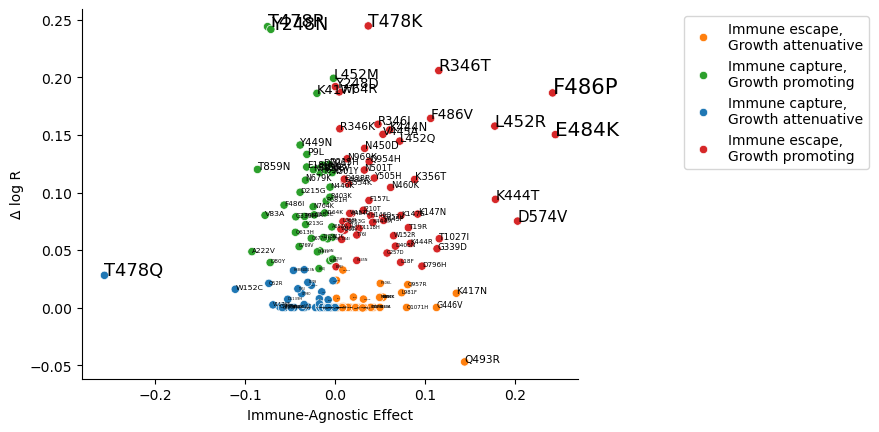

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(x='Immune-Agnostic Effect',
                y='Δ log R',
                hue='Mut variety',
                palette=mut_variety_palette,
                data=pyro_escape,
                ax=ax);
for _, row in pyro_escape.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Δ log R'],
            row['Mutation'],
            fontsize = np.sqrt(row['Immune-Agnostic Effect']**2 + row['Δ log R']**2)*50)

ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1));
ax.spines[['top', 'right']].set_visible(False);




print('Contingency table:')
print(pyro_escape[['Immune-Agnostic Effect', 'Δ log R']].corr())

slope, intercept, r_value, p_value, std_err = linregress(pyro_escape['Immune-Agnostic Effect'].values, pyro_escape['Δ log R'].values)
print('R^2, pvalue:')
print(r_value)
print(p_value)

print('Accuracy score:')
print(accuracy_score(pyro_escape['Immune Escape'].values, pyro_escape['Growth'].values))
contingency = pyro_escape[['Mutation', 'Immune Escape', 'Growth']].groupby(['Immune Escape', 'Growth']).agg('nunique').reset_index().pivot(columns='Growth', index='Immune Escape', values='Mutation')
contingency

Correlation:
                        Immune-Agnostic Effect      Beta
Immune-Agnostic Effect                1.000000  0.249767
Beta                                  0.249767  1.000000
R^2, pvalue:
0.24976711212617062
0.00047617160810948226
Accuracy:
0.5104166666666666


Growth,False,True
Immune Escape,,
False,46,44
True,50,52


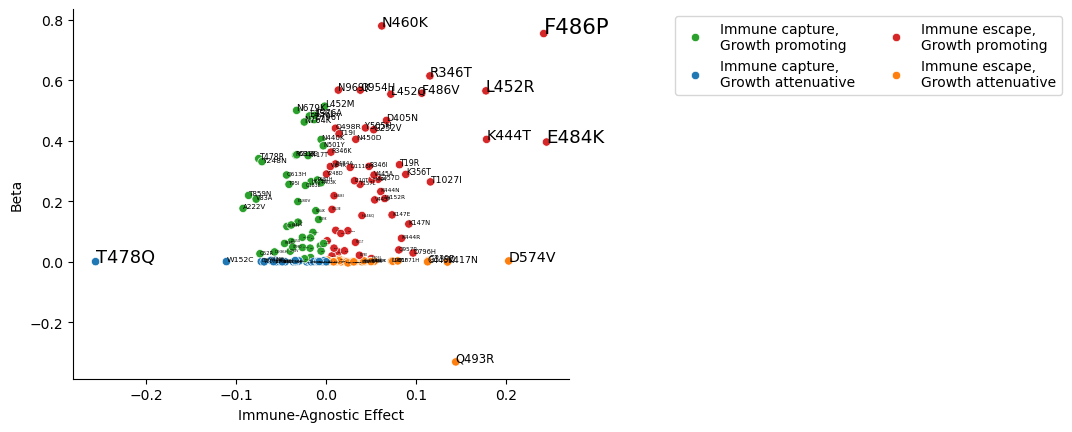

In [179]:
mut_variety_palette = {'Immune capture,\nGrowth attenuative':'tab:blue',
                       'Immune escape,\nGrowth attenuative':'tab:orange',
                       'Immune capture,\nGrowth promoting':'tab:green',
                       'Immune escape,\nGrowth promoting':'tab:red'}



fig, ax = plt.subplots()
sns.scatterplot(x='Immune-Agnostic Effect',
                y='Beta',
                hue='Mut variety',
                hue_order=['Immune capture,\nGrowth promoting',
                           'Immune capture,\nGrowth attenuative',
                           'Immune escape,\nGrowth promoting',
                           'Immune escape,\nGrowth attenuative'],
                palette=mut_variety_palette,
                data=bvas_escape,
                ax=ax);
for _, row in bvas_escape.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Beta'],
            row['Mutation'],
            fontsize = np.sqrt(row['Immune-Agnostic Effect']**2 + (row['Beta']/4)**2)*50)

ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1), ncol=2);
ax.spines[['top', 'right']].set_visible(False);
fig.savefig('figs/ALTERNATE_FIGURE_4/scatter.png', dpi=250, bbox_inches='tight');

print('Correlation:')
print(bvas_escape[['Immune-Agnostic Effect', 'Beta']].corr())

slope, intercept, r_value, p_value, std_err = linregress(bvas_escape['Immune-Agnostic Effect'].values, bvas_escape['Beta'].values)
print('R^2, pvalue:')
print(r_value)
print(p_value)

print('Accuracy:')
print(accuracy_score(bvas_escape['Immune Escape'].values, bvas_escape['Growth'].values))
contingency = bvas_escape[['Mutation', 'Immune Escape', 'Growth']].groupby(['Immune Escape', 'Growth']).agg('nunique').reset_index().pivot(columns='Growth', index='Immune Escape', values='Mutation')
contingency

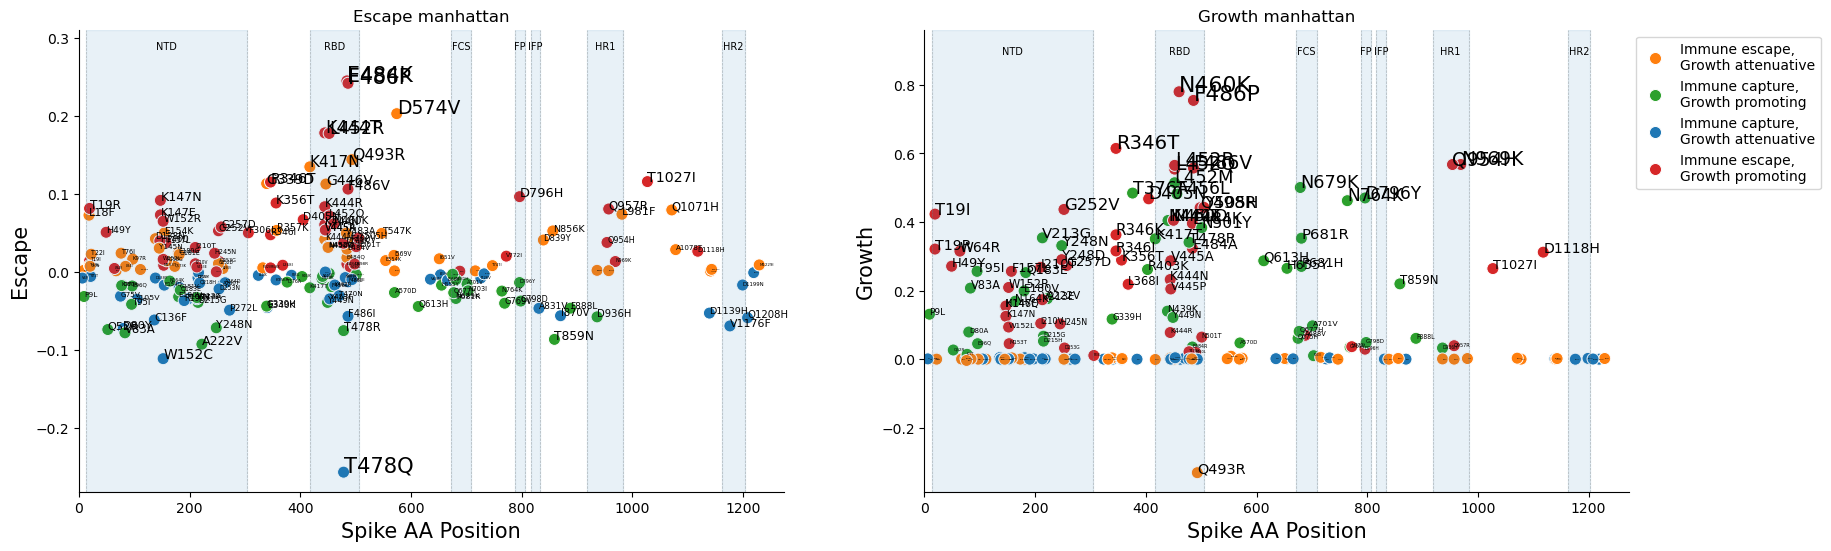

In [174]:
def plot_regions(ax, options):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    
    for r in regions:
        ax.vlines(regions[r], options['ylim'][0], options['ylim'][1], linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.fill_between(regions[r], options['ylim'][0], options['ylim'][1], color='tab:blue', alpha=0.1)
        ax.text(np.mean(regions[r]), options['ylim'][1]*0.95, r, ha='center', va='top', fontsize=7)

    ax.set_ylim(options['ylim']);
    

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax = axes[0]
ax.set_title('Escape manhattan');
# sns.scatterplot(x='Position',
#                 y='Immune-Agnostic Effect',
#                 hue='Mut variety',
#                 palette=mut_variety_palette,
#                 s=75,
#                 data=pyro_escape,
#                 ax=ax);
sns.scatterplot(x='Position',
                y='Immune-Agnostic Effect',
                hue='Mut variety',
                palette=mut_variety_palette,
                s=75,
                data=bvas_escape,
                ax=ax);
for _, row in pyro_escape.iterrows():
    ax.text(row['Position'],
            row['Immune-Agnostic Effect'],
            row['Mutation'],
            fontsize = 30*np.sqrt(np.abs(row['Immune-Agnostic Effect'])))
ax.set_ylabel('Escape')
ax.legend().set_visible(False);
ax.spines[['top', 'right']].set_visible(False);

ax = axes[1]
ax.set_title('Growth manhattan');
# sns.scatterplot(x='Position',
#                 y='Δ log R',
#                 hue='Mut variety',
#                 palette=mut_variety_palette,
#                 s=75,
#                 data=pyro_escape,
#                 ax=ax);
# for _, row in pyro_escape.iterrows():
#     ax.text(row['Position'],
#             row['Δ log R'],
#             row['Mutation'],
#             fontsize = 25*np.sqrt(np.abs(row['Δ log R'])))
sns.scatterplot(x='Position',
                y='Beta',
                hue='Mut variety',
                palette=mut_variety_palette,
                s=75,
                data=bvas_escape,
                ax=ax);
for _, row in bvas_escape.iterrows():
    ax.text(row['Position'],
            row['Beta'],
            row['Mutation'],
            fontsize = 18*np.sqrt(np.abs(row['Beta'])))
ax.set_ylabel('Growth');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.spines[['top', 'right']].set_visible(False);

for ax in axes:
    xlim = ax.get_xlim();
    ylim = ax.get_ylim()
    ylim = [ylim[0], 1.15*ylim[1]]
    options = {'ylim':ylim}
    plot_regions(ax, options);
    ax.set_xlim([0, 1273]);
    ax.set_xlabel('Spike AA Position', fontsize=15);
    ax.set_ylabel(ax.get_ylabel(), fontsize=15);
    
fig.savefig('figs/ALTERNATE_FIGURE_4/manhattans.png')

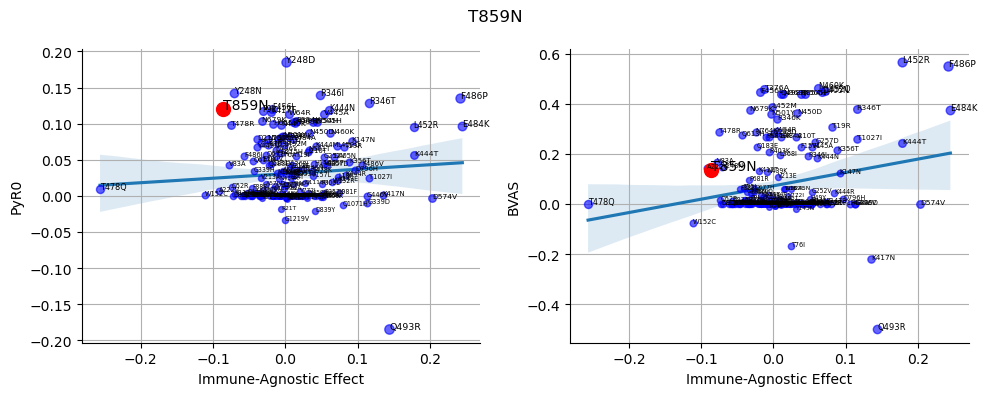

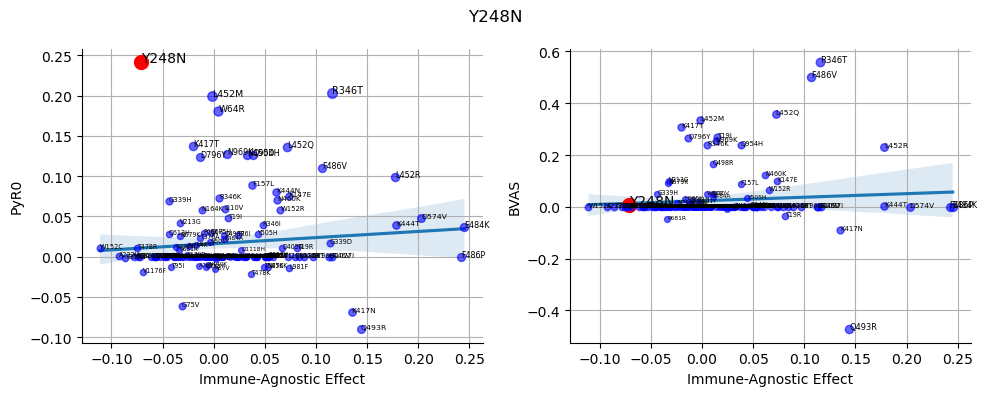

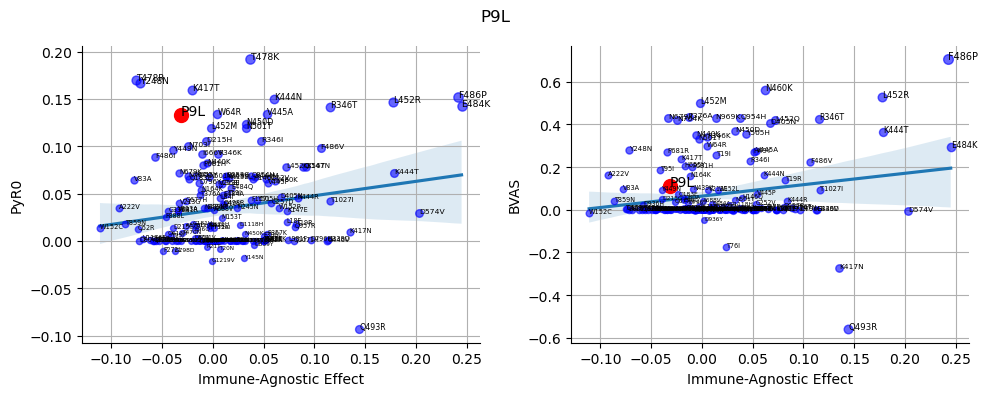

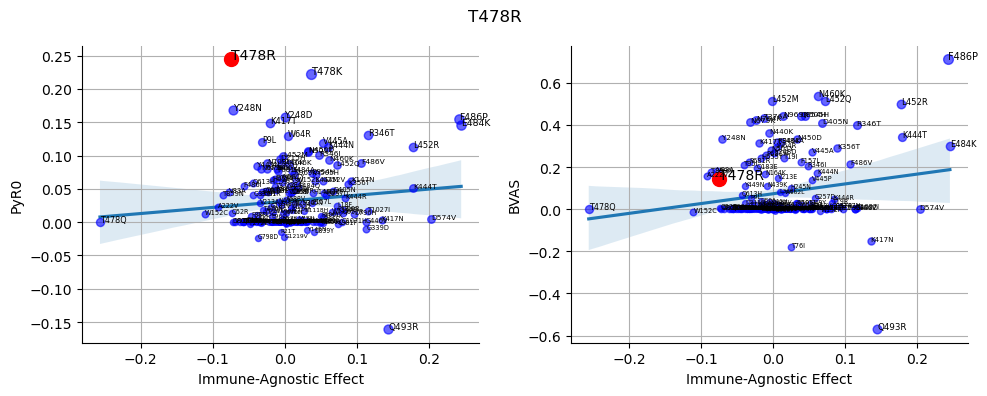

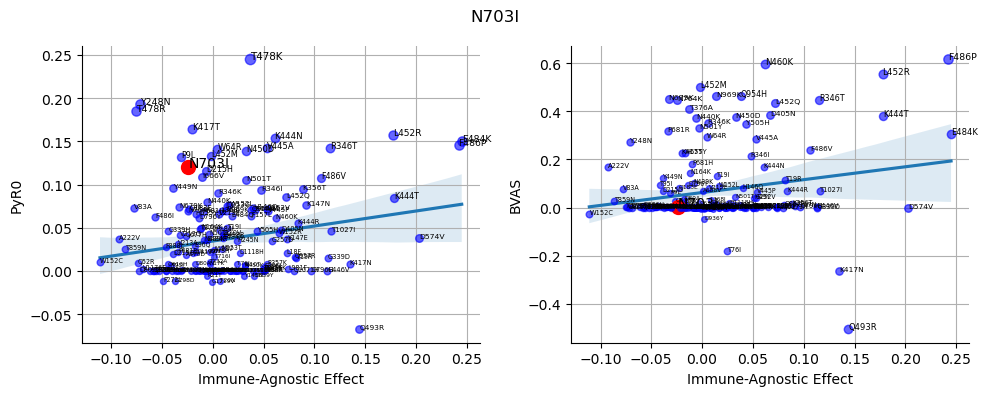

In [165]:
muts_to_inspect = ['T859N', 'Y248N', 'P9L', 'T478R', 'N703I']#['Q493R','T478R','Y248N','T859N','P9L','K417N','G446V','L452M','N703I','N679K','D796Y']  #'S704L',

for mut in muts_to_inspect:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    max_growth = pyro[pyro['Mutation']==mut]['Δ log R'].max()
    max_date = pyro[(pyro['Mutation']==mut) & (pyro['Δ log R']==max_growth)]['Run date'].values.tolist()[0]
    closest_bvas_date = bvas.loc[(bvas['Run date'] - pd.to_datetime(max_date)).abs().idxmin(), 'Run date']
    
    ax = axes[1]
    bvas_temp = bvas[bvas['Run date']==closest_bvas_date]
    temp_df = pd.merge(bvas_temp, pool_agnostic_effects, on='Mutation')
    sns.regplot(
                x='Immune-Agnostic Effect',
                y='Beta',
                data=temp_df,
                scatter=False,
                ax=ax);
    for _, row in temp_df.iterrows():
        x = row['Immune-Agnostic Effect']
        y = row['Beta']
        if row['Mutation'] == mut:
            size = 10
            color = 'red'
            alpha=1
        else:
            size = 4 + 7*np.sqrt(x**2 + (y/2)**2)
            color='blue'
            alpha=0.6
        ax.plot(x, y, 'o', color=color, alpha=alpha, markersize=size);
        ax.text(x,
                y,
                row['Mutation'],
                fontsize = size)

    ax.set_ylabel('BVAS');

    
    ax = axes[0]
    pyro_temp = pyro[pyro['Run date']==pd.to_datetime(max_date)]
    temp_df = pd.merge(pyro_temp, pool_agnostic_effects, on='Mutation')

    sns.regplot(x='Immune-Agnostic Effect',
                y='Δ log R',
                data=temp_df,
                scatter=False,
                ax=ax);

    for _, row in temp_df.iterrows():
        x = row['Immune-Agnostic Effect']
        y = row['Δ log R']
        if row['Mutation'] == mut:
            size = 10
            color = 'red'
            alpha = 1
        else:
            size = 4 + 7*np.sqrt(x**2 + (2*y)**2)
            color = 'blue'
            alpha = 0.6
        ax.plot(x, y, 'o', color=color, alpha=alpha, markersize=size);
        ax.text(x,
                y,
                row['Mutation'],
                fontsize = size)

    ax.set_ylabel('PyR0');

        
    for ax in axes:
        ax.grid(True);
        ax.spines[['top', 'right']].set_visible(False);
            
    fig.suptitle(mut);
    fig.tight_layout();
    fig.savefig(f'figs/SUPPLEMENTAL_FIGURES/{mut}.png', dpi=200)

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_46740/3973230126.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_46740/3973230126.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_46740/3973230126.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_46740/3973230126.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_4

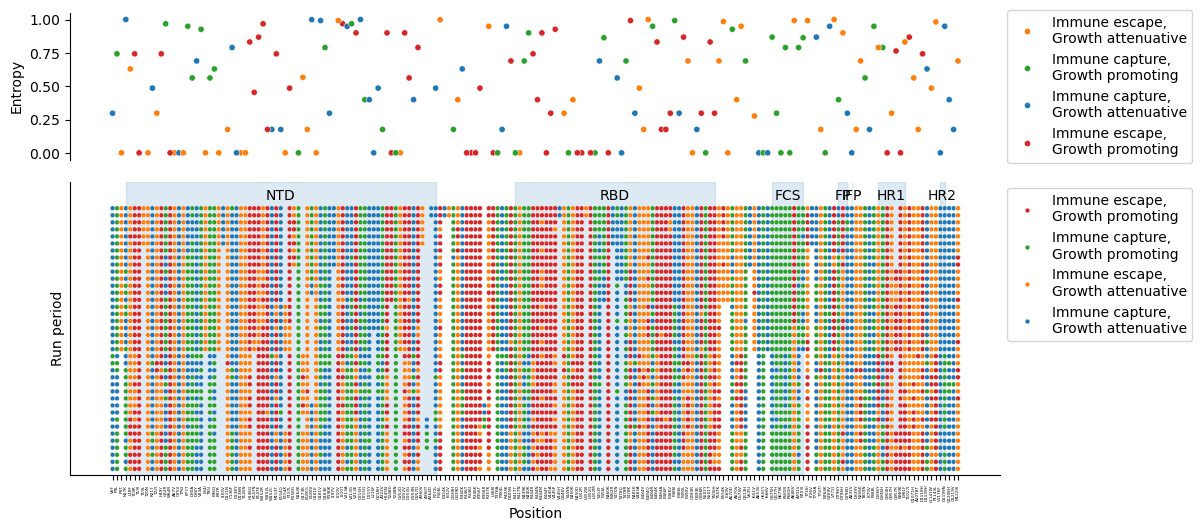

In [32]:
def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'


# growth_escape_time = pd.merge(pyro, pool_agnostic_effects, on='Mutation')
# growth_escape_time['Run period'] = growth_escape_time['Run date']
# # growth_escape_time = all_df[(~all_df['Immune-Agnostic Effect'].isna()) & (~all_df['Run period'].isna())].sort_values(by='Run period')
# growth_escape_time['Run period'] = growth_escape_time['Run date']
# growth_escape_time['Position'] = growth_escape_time['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))
# medians = growth_escape_time.groupby('Run period')['Δ log R'].transform('median')
# growth_escape_time['Growth'] = growth_escape_time['Δ log R'] > medians
# growth_escape_time['Immune Escape'] = growth_escape_time['Immune-Agnostic Effect'] > 0
# growth_escape_time['Mut variety'] = growth_escape_time.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
#                                                                          f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)
growth_escape_time = pd.merge(bvas, pool_agnostic_effects, on='Mutation')
growth_escape_time['Run period'] = growth_escape_time['Run date']
# growth_escape_time = all_df[(~all_df['Immune-Agnostic Effect'].isna()) & (~all_df['Run period'].isna())].sort_values(by='Run period')
growth_escape_time['Run period'] = growth_escape_time['Run date']
growth_escape_time['Position'] = growth_escape_time['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))
medians = growth_escape_time.groupby('Run period')['Beta'].transform('median')
growth_escape_time['Growth'] = growth_escape_time['Beta'] > medians
growth_escape_time['Immune Escape'] = growth_escape_time['Immune-Agnostic Effect'] > 0
growth_escape_time['Mut variety'] = growth_escape_time.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                                                         f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)



# Columns for plotting
mut_pos_df = growth_escape_time[['Mutation', 'Position']].drop_duplicates().sort_values(by='Position', ascending=True).reset_index(drop=True)
mut_pos_df['y'] = mut_pos_df.index
mut_pos_df['Region'] = mut_pos_df['Position'].apply(get_region)

run_period_cat_df = growth_escape_time[['Run period']].drop_duplicates().sort_values(by='Run period', ascending=True).reset_index(drop=True)
run_period_cat_df['x'] = run_period_cat_df.index

growth_escape_time = pd.merge(growth_escape_time, mut_pos_df, on=['Mutation', 'Position'])
growth_escape_time = pd.merge(growth_escape_time, run_period_cat_df, on=['Run period'])



fig, axes = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios':[1,2]})

ax = axes[1]
sns.scatterplot(x='y',
                y='x',
                s=12,
                # marker='s',
                hue='Mut variety',
                palette=mut_variety_palette,
                data=growth_escape_time,
                ax=ax);

ylim = ax.get_ylim();
ylim = [ylim[0]+1, 1.05*ylim[1]]
for reg, row in mut_pos_df[['Region', 'y']].groupby('Region').agg(start=('y',min),
                                                                  end=('y',max)).iterrows():
    if not reg=='Other':
        ax.fill_between([row['start'], row['end']], [ylim[0], ylim[0]], [ylim[1], ylim[1]],
                        color='tab:blue', alpha=0.15, zorder=-1);
        ax.text(np.mean([row['start'], row['end']]), ylim[1]-1, reg, ha='center', va='top');
ax.set_ylim(ylim);
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
# ax.set_xticks([]); 
ax.set_xticks(sorted(growth_escape_time['y'].unique().tolist()))
ax.set_xticklabels(growth_escape_time[['y', 'Mutation']].drop_duplicates().sort_values(by='y')['Mutation'].tolist(),
                  rotation=90, fontsize=3, ha='center');
ax.set_yticks([]);
ax.set_xlabel('Position');
ax.set_ylabel('Run period');
ax.spines[['top', 'right']].set_visible(False);

xlim = ax.get_xlim();




ax = axes[0]
def entropy_cat(series):
    if len(series) < 10:
        return None
    # Count frequency of each category
    value_counts = series.value_counts(normalize=True)
    return entropy(value_counts, base=2)  # base 2 gives bits

def mode_string(series):
    mode_vals = series.mode()
    if mode_vals.empty:
        return None
    return mode_vals.iloc[0]  # Return the first mode if there's a tie

entropy_df = (
    growth_escape_time[['Mutation', 'y', 'Mut variety']]
    .groupby(['Mutation', 'y'])
    .agg(Entropy=('Mut variety', entropy_cat),
         Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
    .reset_index()
    # .rename(columns={'Mut variety': 'Entropy'})
)
entropy_df = pd.merge(entropy_df,
                      growth_escape_time[['Mutation', 'Mut variety']].groupby('Mutation').agg(mode_string).reset_index(),
                      on='Mutation')

sns.scatterplot(x='y',
                y='Entropy',
                data=entropy_df,
                s=20,
                hue='Mut variety',
                palette=mut_variety_palette,
                # size='Entropy',
                # sizes=(10,100),
                ax=ax);
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_xlim(xlim);
ax.xaxis.set_visible(False);
ax.spines[['top', 'bottom', 'right']].set_visible(False);

fig.subplots_adjust(hspace=0.1);
fig.savefig('figs/ALTERNATE_FIGURE_4/manhattan_regime.png', dpi=400);

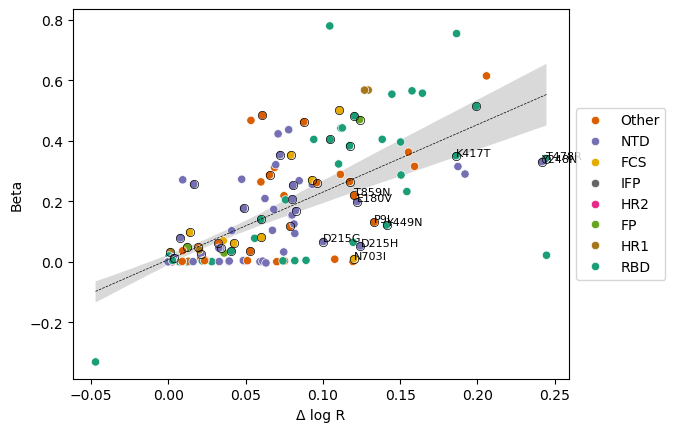

In [159]:
pyro_bvas = pd.merge(bvas_escape, pyro_max, on='Mutation')
pyro_bvas['Region'] = pyro_bvas['Position'].apply(lambda x: get_region(x))
# pyro_bvas_dms = pd.merge(pyro_bvas, dms, on='Mutation')
# pyro_bvas_dms['Infectivity'] = (pyro_bvas_dms['spike mediated entry'] > np.mean(pyro_bvas_dms['spike mediated entry'])) & \
#                                (pyro_bvas_dms['ACE2 binding'] > np.mean(pyro_bvas_dms['ACE2 binding']))

marked_muts = ['T859N', 'Y248N', 'P9L', 'T478R', 'N703I', 'K417T', 'Y449N', 'D215H', 'E180V', 'D215G']

fig, ax = plt.subplots()

p = sns.regplot(
    y='Beta',
    x='Δ log R',
    data=pyro_bvas,
    scatter=False,
    color='black',
    line_kws=dict(linestyle="--", linewidth=0.5),
    # hue='Mut variety',
    # palette=mut_variety_palette,
    ax=ax);
sns.scatterplot(
    y='Beta',
    x='Δ log R',
    data=pyro_bvas,
    # scatter=False,
    hue='Region',#'Mut variety',
    palette=region_palette,#mut_variety_palette,
    ax=ax);

slope, intercept, r, p, sterr = linregress(x=p.get_lines()[0].get_xdata(),
                                           y=p.get_lines()[0].get_ydata())

for _, row in pyro_bvas[pyro_bvas['Mutation'].apply(lambda x: x in marked_muts)].iterrows():
    x = row['Δ log R']
    y = row['Beta']
    mut = row['Mutation']
    ax.text(x, y, mut, fontsize=8)
    # if (row['Mut variety']=='Immune capture,\nGrowth promoting') and (row['Δ log R'] > np.median(pyro_bvas['Δ log R'])):
        # if (slope*x + intercept > 1.1*y):
        #     ax.text(x, y, mut)
        # if (slope*x + intercept < 0.9*y):
        #     ax.text(x, y, mut)

for _, row in pyro_bvas[pyro_bvas['Mut variety']=='Immune capture,\nGrowth promoting'].iterrows():
    x = row['Δ log R']
    y = row['Beta']
    ax.plot(x, y, 'o', color='k', mfc='none', markeredgewidth=0.5);
        
# for _, row in pyro_bvas_dms[pyro_bvas_dms['Infectivity']].iterrows():
#     x = row['Δ log R']
#     y = row['Beta']
#     ax.plot(x, y, 'o', color='k', mfc='none');

ax.legend(loc='center left', bbox_to_anchor=(1,0.5));

### Other correlations

Optimization terminated successfully.
         Current function value: 0.648764
         Iterations 5
[0.00157251]
[[43 17]
 [44 42]]
0.5821917808219178


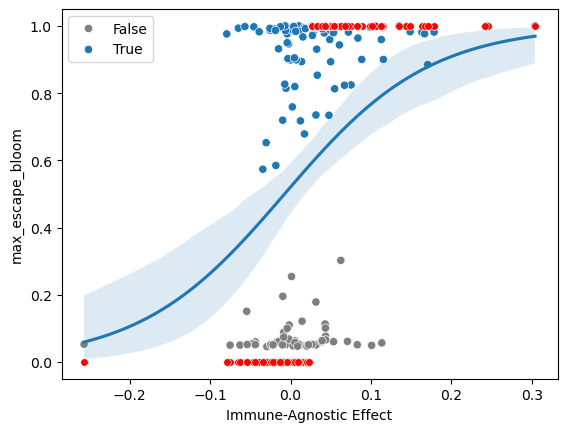

In [12]:
escape_dms = pd.read_csv('data/EVEscape/spike_evescape_predictions.csv', index_col=0)
escape_dms['Mutation'] = escape_dms['wt'].astype(str) + escape_dms['i'].astype(str) + escape_dms['mut'].astype(str)
escape_dms = escape_dms[['Mutation', 'max_escape_bloom', 'max_escape_xie']].dropna()

# Univariate Logistic Regression
regressors = ['Immune-Agnostic Effect'] # 'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']
regressand = ['max_escape_bloom'] # ['max_escape_xie']

Xy = pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='outer')[regressors+regressand].dropna()
X = Xy[regressors].values
y = Xy[regressand].values > 0.5


standard_scaler=True
# Standardize predictors
if standard_scaler:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Fit regression
model = sm.Logit(y, X)
model = model.fit()
y_pred = list(map(round, model.predict(X)))
# r2 = model.score(X, y)
pvals = model.pvalues
cm = confusion_matrix(y, y_pred)

fig, ax = plt.subplots()
sns.regplot(x=regressors[0],
            y=regressand[0],
            logistic=True,
            data=Xy,
            scatter=False,
            ax=ax);
sns.scatterplot(x=regressors[0],
                y=regressand[0],
                data=Xy.assign(dms_escape_bin=lambda x: x[regressand[0]]>0.5),
                hue='dms_escape_bin',
                palette={False:'tab:gray', True:'tab:blue'},
                ax=ax);
sns.scatterplot(x=scaler.inverse_transform(X).squeeze() if standard_scaler else X.squeeze(),
                y=y_pred,
                marker='o',
                color='red',
                s=30,
                ax=ax);

# print(r2)
print(pvals)
print(cm)
print(accuracy_score(y, y_pred))

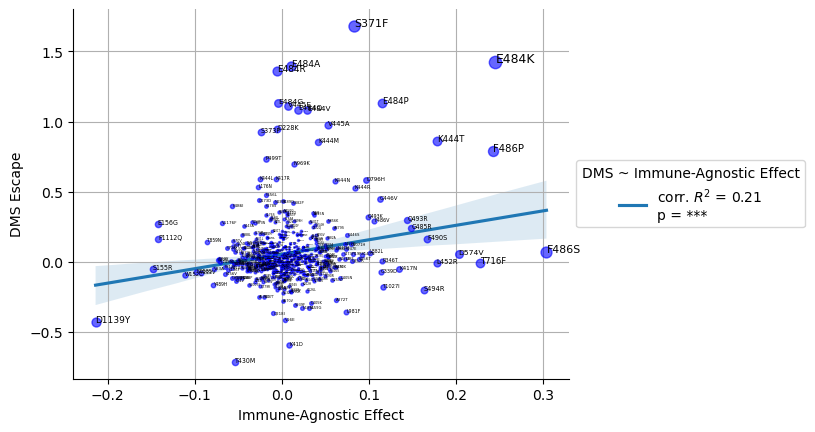

In [13]:
# Neutralization DMS
# https://pmc.ncbi.nlm.nih.gov/articles/PMC9922669/#sec4

# BA.1
dadonaite_ba1_constructs_cc67105_escape = pd.read_csv('https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/refs/heads/main/results/antibody_escape/CC67.105_avg.csv')
dadonaite_ba1_constructs_cc9104_escape = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/raw/refs/heads/main/results/antibody_escape/CC9.104_avg.csv')
dadonaite_ba1_constructs_lycov1404_escape = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/raw/refs/heads/main/results/antibody_escape/LyCoV-1404_avg.csv')
dadonaite_ba1_constructs_ntd57_escape = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/raw/refs/heads/main/results/antibody_escape/NTD_5-7_avg.csv')
# Record antibodies
dadonaite_ba1_constructs_cc67105_escape['Antibody'] = 'CC67.105'
dadonaite_ba1_constructs_cc9104_escape['Antibody'] = 'CC9.104'
dadonaite_ba1_constructs_lycov1404_escape['Antibody'] = 'LyCoV-1404'
dadonaite_ba1_constructs_ntd57_escape['Antibody'] = 'NTD_5-7'
# Concat
dadonaite_ba1_all = pd.concat([dadonaite_ba1_constructs_cc67105_escape, 
                               dadonaite_ba1_constructs_cc9104_escape,
                               dadonaite_ba1_constructs_lycov1404_escape,
                               dadonaite_ba1_constructs_ntd57_escape])
dadonaite_ba1_all['Base VoC'] = 'BA.1'


# Delta
dadonaite_delta_267c = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Delta_spike_DMS_REGN10933/raw/refs/heads/main/results/antibody_escape/267C_avg.csv')
dadonaite_delta_279c = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Delta_spike_DMS_REGN10933/raw/refs/heads/main/results/antibody_escape/279C_avg.csv')
dadonaite_delta_regn10933 = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Delta_spike_DMS_REGN10933/raw/refs/heads/main/results/antibody_escape/279C_avg.csv')
# Record antibodies
dadonaite_delta_267c['Antibody'] = '267C'
dadonaite_delta_279c['Antibody'] = '279C'
dadonaite_delta_regn10933['Antibody'] = 'REGN10933'
# Concat
dadonaite_delta_all = pd.concat([dadonaite_delta_267c,
                                 dadonaite_delta_279c,
                                 dadonaite_delta_regn10933])
dadonaite_delta_all['Base VoC'] = 'Delta'


# Agg
dadonaite_all = pd.concat([dadonaite_ba1_all, dadonaite_delta_all])
dadonaite_all_means = dadonaite_all[['mutation', 'escape_mean']].groupby('mutation').agg('mean').reset_index().rename(columns={'mutation':'Mutation'})



fig, ax = plt.subplots()

plot_df = pd.merge(dadonaite_all_means, pool_agnostic_effects)
x_var = 'Immune-Agnostic Effect'
y_var = 'escape_mean'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('Immune-Agnostic Effect');
ax.set_ylabel('DMS Escape');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='DMS ~ Immune-Agnostic Effect',
          frameon=True);

# fig.tight_layout();
fig.savefig('figs/ALTERNATE_FIGURE_4/dms_regplot.png', dpi=200, bbox_inches='tight')

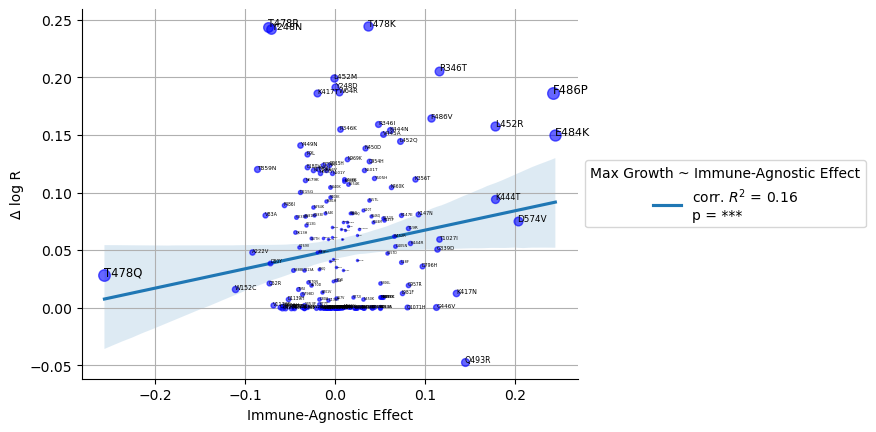

In [14]:
fig, ax = plt.subplots()

plot_df = pd.merge(pyro_max, pool_agnostic_effects)
x_var = 'Immune-Agnostic Effect'
y_var = 'Δ log R'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('Immune-Agnostic Effect');
ax.set_ylabel('Δ log R');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='Max Growth ~ Immune-Agnostic Effect',
          frameon=True);

fig.savefig('figs/ALTERNATE_FIGURE_4/pyro_regplot.png', dpi=200, bbox_inches='tight')

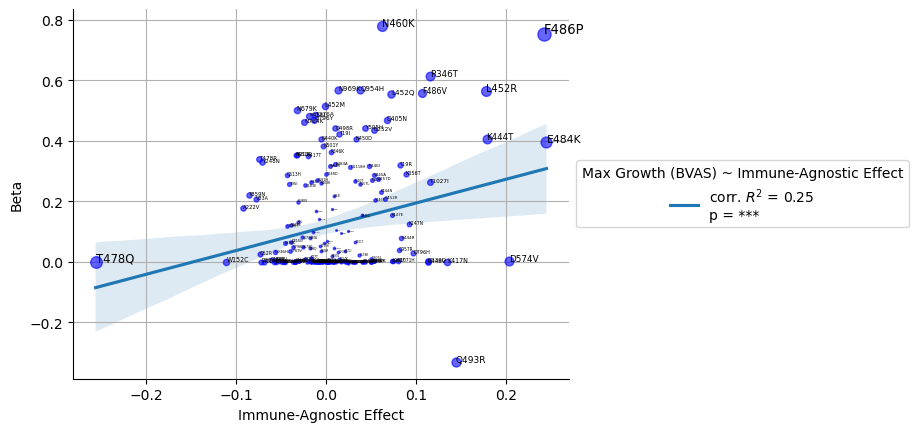

In [15]:
fig, ax = plt.subplots()

plot_df = pd.merge(bvas_max, pool_agnostic_effects)
x_var = 'Immune-Agnostic Effect'
y_var = 'Beta'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('Immune-Agnostic Effect');
ax.set_ylabel('Beta');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='Max Growth (BVAS) ~ Immune-Agnostic Effect',
          frameon=True);

fig.savefig('figs/ALTERNATE_FIGURE_4/bvas_regplot.png', dpi=200, bbox_inches='tight')

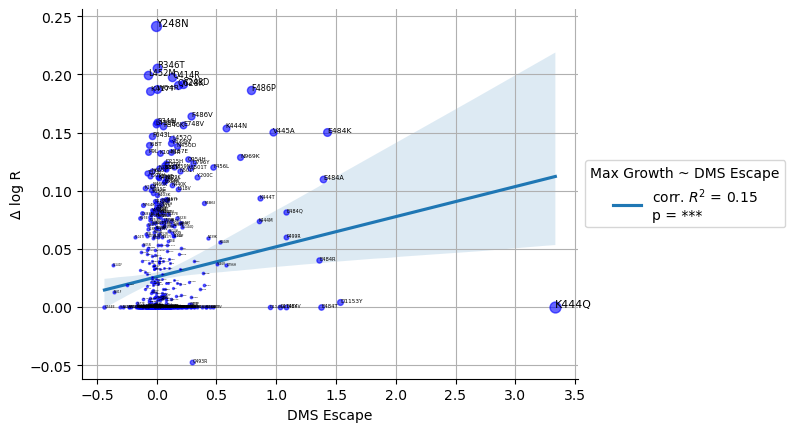

In [16]:
fig, ax = plt.subplots()

plot_df = pd.merge(pyro_max, dadonaite_all_means)
x_var = 'escape_mean'
y_var = 'Δ log R'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('DMS Escape');
ax.set_ylabel('Δ log R');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='Max Growth ~ DMS Escape',
          frameon=True);

fig.savefig('figs/ALTERNATE_FIGURE_4/pyro_dms_regplot.png', dpi=200, bbox_inches='tight')

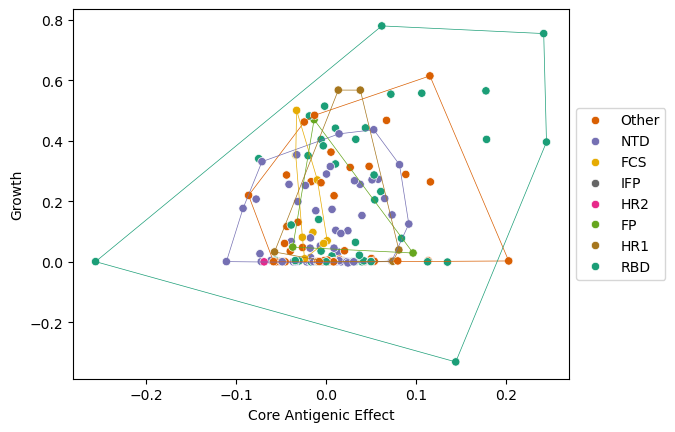

In [183]:
def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'


region_palette = dict({r:c for r,c in zip(['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP'], sns.color_palette('Dark2'))})

bvas_escape['Region'] = bvas_escape['Position'].apply(lambda x: get_region(x))

fig, ax = plt.subplots()
sns.scatterplot(
    x='Immune-Agnostic Effect',
    y='Beta',
    data=bvas_escape,
    hue='Region',
    palette=region_palette,
    ax=ax);

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

from scipy.spatial import ConvexHull
# Region hulls
region_palette = dict({r:c for r,c in zip(['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP'], sns.color_palette('Dark2'))})
for r in bvas_escape['Region'].unique():
    points = np.array(bvas_escape[bvas_escape['Region']==r][['Immune-Agnostic Effect', 'Beta']].values.tolist())
    if points.shape[0]>2:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], linestyle='-', linewidth=0.5, color=region_palette[r])
            # ax.fill(points[hull.vertices, 0], points[hull.vertices, 1],
            #          facecolor=region_palette[r], alpha=0.01, zorder=-1)
            
ax.set_ylabel('Growth');
ax.set_xlabel('Core Antigenic Effect');

fig.savefig('figs/SUPPLEMENTAL_FIGURES/manifolds.png', dpi=150, bbox_inches='tight');

In [19]:
# Survival curves
pattern = r'^\d{4}-\d{2}-\d{2}$'   # YYYY-MM-DD date pattern
# Tensors to hold counts
seq_counts = torch.tensor([]); seq_dates = []
mut_counts = torch.tensor([[]]); mut_dates = []; mut_list = []

for chunk in tqdm(pd.read_csv('data/GISAID/metadata_2025_06_22.tsv.gz', compression='gzip', sep='\t', chunksize=100000)):
    # Match YYYY-MM-DD date pattern
    chunk = chunk[chunk['Collection date'].astype(str).str.match(pattern)]
    chunk = chunk[['Collection date', 'AA Substitutions', 'Accession ID']].dropna()
    
    # Count sequences
    seq_chunk = chunk.groupby('Collection date').agg('nunique').reset_index()
    seq_chunk_counts = seq_chunk['Accession ID'].values.tolist()         # Counts in this chunk
    seq_chunk_dates = seq_chunk['Collection date'].values.tolist()       # Dates in this chunk
    seq_dates += list(set(seq_chunk_dates) - set(seq_dates))             # Comprehensive list of dates
    # Create empty tensor
    seq_counts_pad = torch.zeros(len(seq_dates))
    # Populate with existing counts
    seq_counts_pad[:seq_counts.shape[0]] = seq_counts
    # Add in new data
    seq_date_idx = [seq_dates.index(d) for d in seq_chunk_dates]
    seq_counts_pad[seq_date_idx] += torch.tensor(seq_chunk_counts)
    # Save
    seq_counts = seq_counts_pad
    
    # Count mutations
    mut_chunk = chunk.copy()
    mut_chunk['AA Substitutions'] = mut_chunk['AA Substitutions'].apply(lambda x: x.replace(')','').replace('(','').split(','))
    mut_chunk['AA Substitutions'] = mut_chunk['AA Substitutions'].apply(lambda x: [mut.replace('Spike_','') for mut in x if mut.startswith('Spike_')])
    mut_chunk = mut_chunk.explode('AA Substitutions').groupby(['AA Substitutions', 'Collection date'])['Accession ID'].agg('nunique').reset_index()
    mut_chunk = mut_chunk.pivot(index='Collection date', columns='AA Substitutions', values='Accession ID').fillna(0) 
    mut_chunk_counts = mut_chunk.values                       # Counts in this chunk
    mut_chunk_dates = mut_chunk.index.tolist()                # Dates in this chunk
    mut_chunk_list = mut_chunk.columns.tolist()               # Mutations in this chunk
    mut_dates += list(set(mut_chunk_dates) - set(mut_dates))  # Comprehensive list of dates
    mut_list += list(set(mut_chunk_list) - set(mut_list))     # Comprehensive list of muts
    # Create empty tensor
    mut_counts_pad = torch.zeros(len(mut_dates), len(mut_list))
    # Populate with existing counts
    mut_counts_pad[:mut_counts.shape[0], :mut_counts.shape[1]] = mut_counts
    # Add in new data
    mut_date_idx = torch.tensor([mut_dates.index(d) for d in mut_chunk_dates])     # shape: len(mut_date_idx)
    mut_list_idx = torch.tensor([mut_list.index(m) for m in mut_chunk_list])       # shape: len(mut_list_idx)
    # "zip" idx pairs
    mut_date_idx = mut_date_idx[:, None].expand(-1, mut_list_idx.size(0))          # shape: [len(mut_date_idx), len(mut_list_idx)]
    mut_list_idx = mut_list_idx[None, :].expand(mut_date_idx.size(0), -1)          # shape: [len(mut_date_idx), len(mut_list_idx)]
    zipped_idxs = (mut_date_idx, mut_list_idx)
    # Add
    mut_counts_pad.index_put_(zipped_idxs, torch.tensor(mut_chunk_counts).to(mut_counts_pad.dtype), accumulate=True)
    # Save
    mut_counts = mut_counts_pad

171it [14:40,  4.93s/it]/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
173it [14:47,  5.13s/it]


In [20]:
mut_counts_df = pd.DataFrame(columns=mut_list, index=mut_dates, data=mut_counts).melt(var_name='Mutation', value_name='Count', ignore_index=False)
mut_counts_df = mut_counts_df.reset_index().rename(columns={'index':'Collection date', 'Count':'Mut count'})

seq_counts_df = pd.DataFrame(index=seq_dates, data=seq_counts).rename(columns={0:'Count'})
seq_counts_df = seq_counts_df.reset_index().rename(columns={'index':'Collection date', 'Count':'Seq count'})

muller_df = pd.merge(mut_counts_df, seq_counts_df, on='Collection date')
muller_df['Mut prop'] = muller_df['Mut count'] / muller_df['Seq count']
muller_df

,Collection date,Mutation,Mut count,Seq count,Mut prop
0,2024-12-14,A67Q,0.0,520.0,0.0
1,2024-12-14,S383T,0.0,520.0,0.0
2,2024-12-14,S71F,0.0,520.0,0.0
3,2024-12-14,L118I,0.0,520.0,0.0
4,2024-12-14,S637A,0.0,520.0,0.0
...,...,...,...,...,...
61984460,2019-12-31,ins859A,0.0,2.0,0.0
61984461,2019-12-31,K835C,0.0,2.0,0.0
61984462,2019-12-31,ins502stopW,0.0,2.0,0.0
61984463,2019-12-31,ins16AAF,0.0,2.0,0.0


In [21]:
muller_df[['Mutation', 'Mut prop']].groupby('Mutation').agg(max).reset_index().sort_values(by='Mut prop', ascending=False).head(40)

,Mutation,Mut prop
13236,N460K,1.0
10811,L24del,1.0
20030,T572I,1.0
7402,H245N,1.0
17913,S373P,1.0
17887,S371F,1.0
6405,G446S,1.0
17799,S31P,1.0
9590,K444R,1.0
2977,D614G,1.0


In [22]:
muller_df[muller_df['Mutation']=='T859N'].sort_values(by='Mut prop', ascending=False)

,Collection date,Mutation,Mut count,Seq count,Mut prop
14667617,2021-04-11,T859N,179.0,9115.0,0.019638
47266392,2021-06-09,T859N,188.0,9953.0,0.018889
25086747,2021-04-10,T859N,224.0,11877.0,0.018860
33634177,2021-05-05,T859N,287.0,15471.0,0.018551
43460602,2021-05-16,T859N,109.0,5935.0,0.018366
...,...,...,...,...,...
25055552,2024-03-28,T859N,0.0,842.0,0.000000
25024357,2024-05-03,T859N,0.0,858.0,0.000000
24961967,2023-08-29,T859N,0.0,4057.0,0.000000
24930772,2022-11-09,T859N,0.0,10506.0,0.000000


In [ ]:
# Pull some infectivity data from Starr, et. al., 2020
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7418704/
# Data here: https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/refs/heads/master/results/single_mut_effects/single_mut_effects.csv
dms = pd.read_csv('https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/refs/heads/master/results/single_mut_effects/single_mut_effects.csv')
dms['Mutation'] = dms['wildtype'].astype(str) + dms['site_SARS2'].astype(str) + dms['mutant'].astype(str)
dms

In [ ]:
# Pull some infectivity data from Dadonaite et. al., 2024
# https://www.nature.com/articles/s41586-024-07636-1
# Data here: https://github.com/dms-vep/SARS-CoV-2_XBB.1.5_spike_DMS/blob/main/results/summaries/summary.csv
dms = pd.read_csv('https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_XBB.1.5_spike_DMS/refs/heads/main/results/summaries/summary.csv')
dms['Mutation'] = dms['wildtype'].astype(str) + dms['site'].astype(str) + dms['mutant'].astype(str)
dms

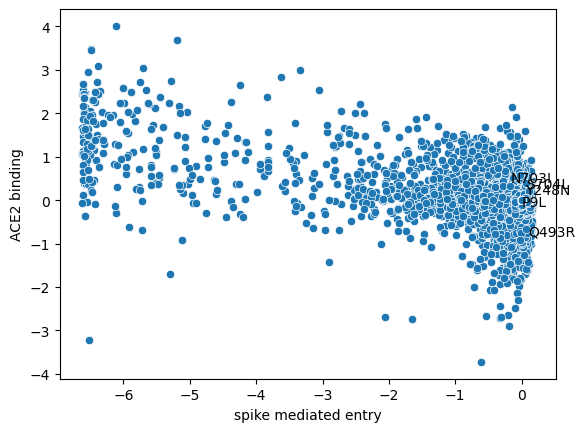

In [24]:
fig, ax = plt.subplots()

sns.scatterplot(x='spike mediated entry',
                y='ACE2 binding',
                data=dms,
                ax=ax);

for mut in ['Q493R', 'Y248N', 'N703I', 'S704L', 'P9L']: # 'T478R', 'D706Y'
    x = dms[dms['Mutation']==mut]['spike mediated entry'].values[0]
    y = dms[dms['Mutation']==mut]['ACE2 binding'].values[0]
    ax.text(x, y, mut);

<Axes: xlabel='ACE2 binding', ylabel='Count'>

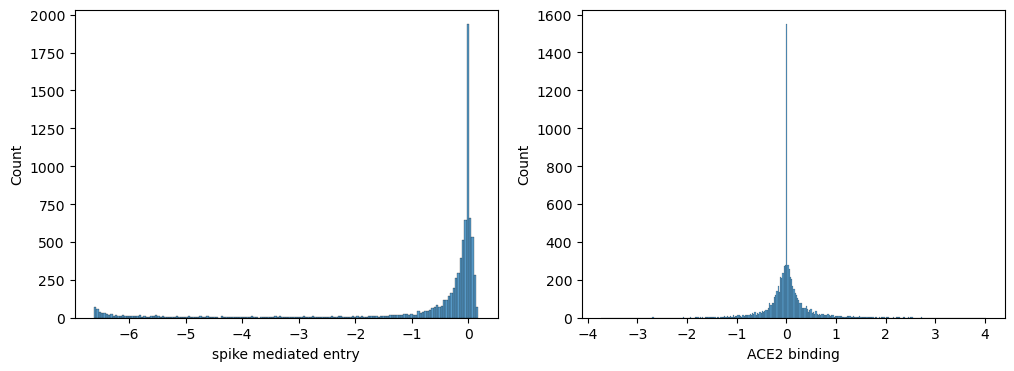

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x='spike mediated entry',
             ax=axes[0],
             data=dms)
sns.histplot(x='ACE2 binding',
             ax=axes[1],
             data=dms)

T478R
Y258N
K417N
G446V
N679K


/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


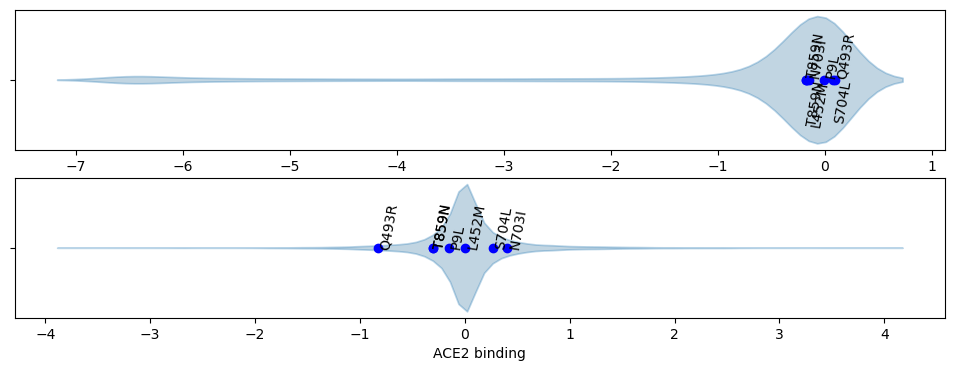

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

sns.violinplot(x='spike mediated entry',
               inner=None,
               alpha=0.3,
               edgecolor='tab:blue',
             ax=axes[0],
             data=dms)
sns.violinplot(x='ACE2 binding',
               inner=None,
               alpha=0.3,
               edgecolor='tab:blue',
             ax=axes[1],
             data=dms)
i = 0 
for mut in ['Q493R','T478R','Y258N','T859N','P9L','K417N','G446V','L452M','N703I','N679K','S704L','T859N']:
    row = dms[dms['Mutation']==mut]
    if len(row)==0:
        print(mut)
        continue
    axes[0].plot(row['spike mediated entry'],
                 0,
                 'bo')
    axes[0].text(row['spike mediated entry'],
                 0,
                 mut, rotation=80, va='bottom' if i%2==0 else 'top')
    axes[1].plot(row['ACE2 binding'],
                 0,
                 'bo')
    axes[1].text(row['ACE2 binding'],
                 0,
                 mut, rotation=80)
    i+=1

/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


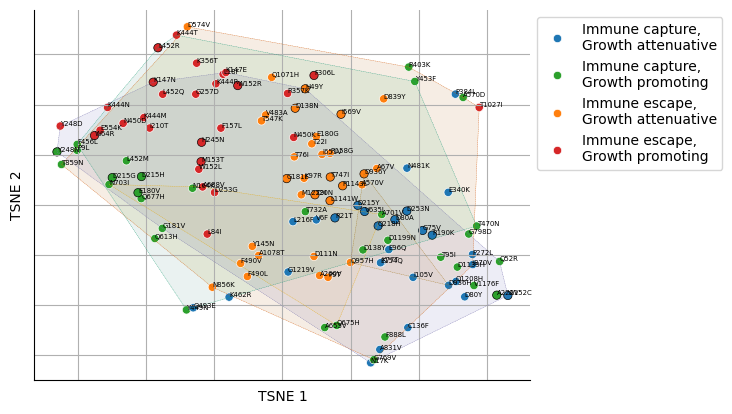

In [27]:
tsne_df = pd.merge(dms.drop(columns='region'),
                   pd.merge(pyro_temp, pool_agnostic_effects, on='Mutation'), 
                   on='Mutation').dropna()
tsne_df['Region'] = tsne_df['site'].apply(lambda x: get_region(x))
tsne_df['Immune Escape'] = tsne_df['Immune-Agnostic Effect'] > 0
tsne_df['Growth'] = tsne_df['Δ log R'] > np.median(tsne_df['Δ log R'])
tsne_df['Binding'] = tsne_df['ACE2 binding'] > np.median(tsne_df['ACE2 binding'])
tsne_df['Entry'] = tsne_df['spike mediated entry'] > np.median(tsne_df['spike mediated entry'])
tsne_df['Mut variety'] = tsne_df.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                                   f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)

from sklearn.manifold import TSNE

X = tsne_df[['Immune-Agnostic Effect', 'Δ log R', 'ACE2 binding', 'spike mediated entry']]
X = StandardScaler().fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=30, random_state=38,
                  init='random').fit_transform(X)

tsne_df['TSNE 1'] = X_embedded[:, 0]
tsne_df['TSNE 2'] = X_embedded[:, 1]

fig, ax = plt.subplots()
sns.scatterplot(x='TSNE 1',
                y='TSNE 2',
                hue='Mut variety',
                palette=mut_variety_palette,
                data=tsne_df,
                ax=ax);
for _, row in tsne_df.iterrows():
    ax.text(row['TSNE 1'],
            row['TSNE 2'],
            row['Mutation'],
            fontsize = 5);
    
# Add convex hulls
from scipy.spatial import ConvexHull
# Region hulls
region_palette = dict({r:c for r,c in zip(['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP'], sns.color_palette('Dark2'))})
for r in tsne_df['Region'].unique():
    points = np.array(tsne_df[tsne_df['Region']==r][['TSNE 1', 'TSNE 2']].values.tolist())
    if points.shape[0]>2:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], linestyle='--', linewidth=0.25, color=region_palette[r])
            ax.fill(points[hull.vertices, 0], points[hull.vertices, 1],
                     facecolor=region_palette[r], alpha=0.01, zorder=-1)
# # Binding hull
# points = np.array(tsne_df[tsne_df['Binding']==True][['TSNE 1', 'TSNE 2']].values.tolist())
# binding_hull = ConvexHull(points)
# for simplex in binding_hull.simplices:
#     ax.plot(points[simplex, 0], points[simplex, 1], 'r--', linewidth=0.25)
# # Entry hull
# points = np.array(tsne_df[tsne_df['Entry']==True][['TSNE 1', 'TSNE 2']].values.tolist())
# entry_hull = ConvexHull(points)
# for simplex in entry_hull.simplices:
#     ax.plot(points[simplex, 0], points[simplex, 1], 'b--', linewidth=0.25)
    
    
# Show binding points
# sns.scatterplot(x='TSNE 1',
#                 y='TSNE 2',
#                 data=tsne_df[tsne_df['Binding']==True],
#                 marker='o',
#                 facecolor=None,
#                 edgecolor='k',
#                 hue='Mut variety',
#                 palette=mut_variety_palette,
#                 legend=False,
#                 ax=ax);
# # # Show entry points
# sns.scatterplot(x='TSNE 1',
#                 y='TSNE 2',
#                 data=tsne_df[tsne_df['Entry']==True],
#                 marker='x',
#                 facecolor='k',
#                 edgecolor='k',
#                 legend=False,
#                 ax=ax);
sns.scatterplot(x='TSNE 1',
                y='TSNE 2',
                data=tsne_df[(tsne_df['Entry']==True) & (tsne_df['Binding']==True)],
                marker='o',
                facecolor=None,
                edgecolor='k',
                hue='Mut variety',
                palette=mut_variety_palette,
                legend=False,
                ax=ax);
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.grid(True);
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(length=0);
ax.spines[['top', 'right']].set_visible(False);